In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["OMP_NUM_THREADS"] = "2"

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
LOAD_PATH = "daten/last_15min.csv"
GEN_PATH  = "daten/erzeugung_15min.csv"

TZ = "Europe/Berlin"
TIME_COL = "Datum von"

LOAD_COL = "Netzlast [MWh] Originalauflösungen"
PV_COL = "Photovoltaik [MWh] Originalauflösungen"
WIND_ON_COL  = "Wind Onshore [MWh] Originalauflösungen"
WIND_OFF_COL = "Wind Offshore [MWh] Originalauflösungen"

CONVERT_TO_MW = True  # MWh/15min -> MW (x4)
MIN_SLOTS_PER_DAY = 90  # wie viele von 96 Slots mindestens vorhanden sein müssen

In [ ]:
def read_csv_auto(path):
    return pd.read_csv(path, sep=None, engine="python")

def clean_columns(df):
    df = df.copy()
    df.columns = [str(c).replace("\ufeff", "").strip() for c in df.columns]
    return df

load_raw = clean_columns(read_csv_auto(LOAD_PATH))
gen_raw  = clean_columns(read_csv_auto(GEN_PATH))

print("LOAD columns:", list(load_raw.columns))
print("GEN  columns:", list(gen_raw.columns))

display(load_raw.head())
display(gen_raw.head())

LOAD columns: ['Datum von', 'Datum bis', 'Netzlast [MWh] Originalauflösungen', 'Netzlast inkl. Pumpspeicher [MWh] Originalauflösungen', 'Pumpspeicher [MWh] Originalauflösungen', 'Residuallast [MWh] Originalauflösungen']
GEN  columns: ['Datum von', 'Datum bis', 'Biomasse [MWh] Originalauflösungen', 'Wasserkraft [MWh] Originalauflösungen', 'Wind Offshore [MWh] Originalauflösungen', 'Wind Onshore [MWh] Originalauflösungen', 'Photovoltaik [MWh] Originalauflösungen', 'Sonstige Erneuerbare [MWh] Originalauflösungen', 'Kernenergie [MWh] Originalauflösungen', 'Braunkohle [MWh] Originalauflösungen', 'Steinkohle [MWh] Originalauflösungen', 'Erdgas [MWh] Originalauflösungen', 'Pumpspeicher [MWh] Originalauflösungen', 'Sonstige Konventionelle [MWh] Originalauflösungen']


,Datum von,Datum bis,Netzlast [MWh] Originalauflösungen,Netzlast inkl. Pumpspeicher [MWh] Originalauflösungen,Pumpspeicher [MWh] Originalauflösungen,Residuallast [MWh] Originalauflösungen
0,01.01.2025 00:00,01.01.2025 00:15,"12.103,00","12.283,25","180,25","3.255,00"
1,01.01.2025 00:15,01.01.2025 00:30,"11.883,75","12.091,00","207,25","3.025,00"
2,01.01.2025 00:30,01.01.2025 00:45,"11.893,25","12.128,25","235,00","3.049,50"
3,01.01.2025 00:45,01.01.2025 01:00,"11.861,75","12.106,75","245,00","3.025,00"
4,01.01.2025 01:00,01.01.2025 01:15,"11.800,00","11.964,50","164,50","2.922,00"


,Datum von,Datum bis,Biomasse [MWh] Originalauflösungen,Wasserkraft [MWh] Originalauflösungen,Wind Offshore [MWh] Originalauflösungen,Wind Onshore [MWh] Originalauflösungen,Photovoltaik [MWh] Originalauflösungen,Sonstige Erneuerbare [MWh] Originalauflösungen,Kernenergie [MWh] Originalauflösungen,Braunkohle [MWh] Originalauflösungen,Steinkohle [MWh] Originalauflösungen,Erdgas [MWh] Originalauflösungen,Pumpspeicher [MWh] Originalauflösungen,Sonstige Konventionelle [MWh] Originalauflösungen
0,01.01.2025 00:00,01.01.2025 00:15,"987,75","358,75","603,75","8.241,75","2,50","32,75",-,"813,25","757,25","1.177,75","113,25","492,00"
1,01.01.2025 00:15,01.01.2025 00:30,"955,75","374,50","650,25","8.206,25","2,25","32,75",-,"816,75","688,75","1.173,75","209,50","466,75"
2,01.01.2025 00:30,01.01.2025 00:45,"941,00","353,00","635,50","8.206,00","2,25","32,75",-,"815,75","682,00","1.162,75","108,75","466,50"
3,01.01.2025 00:45,01.01.2025 01:00,"934,00","354,75","612,50","8.221,75","2,50","33,00",-,"823,75","678,50","1.178,25","26,50","469,75"
4,01.01.2025 01:00,01.01.2025 01:15,"950,00","349,25","563,25","8.312,25","2,50","32,75",-,"957,75","676,75","1.126,75","91,75","468,50"


In [ ]:
def to_berlin_time(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.replace("\ufeff", "", regex=False).str.strip()
    dt = pd.to_datetime(s, format="%d.%m.%Y %H:%M", errors="raise")
    # DST sauber behandeln: fehlende Zeiten nach vorne schieben, doppelte inferieren
    return dt.dt.tz_localize(TZ, ambiguous="infer", nonexistent="shift_forward")

In [ ]:
# =========================
# BLOCK 5: Merge Last + Erzeugung (ROBUST)
# =========================

# Kopien anlegen
load = load_raw.copy()
gen  = gen_raw.copy()

# --- Zeitstempel setzen (Berlin-Zeit) ---
load["ts"] = to_berlin_time(load[TIME_COL])
gen["ts"]  = to_berlin_time(gen[TIME_COL])

# --- Deutsche Zahlen sicher in float umwandeln ---
def to_float_de(s: pd.Series) -> pd.Series:
    # z.B. "1.234,56" -> 1234.56
    txt = s.astype(str).str.replace("\ufeff", "", regex=False).str.strip()
    txt = txt.str.replace(".", "", regex=False).str.replace(",", ".", regex=False)
    return pd.to_numeric(txt, errors="coerce")

# Last
load[LOAD_COL] = to_float_de(load[LOAD_COL])

# Erzeugung
for c in [PV_COL, WIND_ON_COL, WIND_OFF_COL]:
    gen[c] = to_float_de(gen[c])

# Wind summieren
gen["WIND_MWh"] = gen[WIND_ON_COL] + gen[WIND_OFF_COL]

# --- Nur benötigte Spalten, sortieren ---
load_work = load[["ts", LOAD_COL]].sort_values("ts")
gen_work  = gen[["ts", PV_COL, "WIND_MWh"]].sort_values("ts")

# --- Debug: Zeitbereiche prüfen ---
print("Load ts range:", load_work["ts"].min(), "->", load_work["ts"].max())
print("Gen  ts range:", gen_work["ts"].min(),  "->", gen_work["ts"].max())

# --- ROBUSTER Merge (nächstliegender Zeitstempel, ±8 Minuten) ---
df = pd.merge_asof(
    load_work,
    gen_work,
    on="ts",
    direction="nearest",
    tolerance=pd.Timedelta("8min")
)

# Aufräumen & umbenennen
df = (
    df.dropna()
      .rename(columns={
          LOAD_COL: "LOAD_MWh",
          PV_COL: "PV_MWh"
      })
      .sort_values("ts")
)

# --- Kontrolle ---
print("Merged rows:", len(df))
display(df.head())

Load ts range: 2025-01-01 00:00:00+01:00 -> 2025-12-31 23:45:00+01:00
Gen  ts range: 2025-01-01 00:00:00+01:00 -> 2025-12-31 23:45:00+01:00
Merged rows: 35040


,ts,LOAD_MWh,PV_MWh,WIND_MWh
0,2025-01-01 00:00:00+01:00,12103.00,2.50,8845.50
1,2025-01-01 00:15:00+01:00,11883.75,2.25,8856.50
2,2025-01-01 00:30:00+01:00,11893.25,2.25,8841.50
3,2025-01-01 00:45:00+01:00,11861.75,2.50,8834.25
4,2025-01-01 01:00:00+01:00,11800.00,2.50,8875.50


In [ ]:
df["RL_MWh"] = df["LOAD_MWh"] - df["PV_MWh"] - df["WIND_MWh"]

if CONVERT_TO_MW:
    df["LOAD"] = df["LOAD_MWh"] * 4 / 1000
    df["PV"]   = df["PV_MWh"]   * 4 / 1000
    df["WIND"] = df["WIND_MWh"] * 4 / 1000
    df["RL"]   = df["RL_MWh"]   * 4 / 1000
    UNIT = "GW"
else:
    df["LOAD"] = df["LOAD_MWh"]
    df["PV"]   = df["PV_MWh"]
    df["WIND"] = df["WIND_MWh"]
    df["RL"]   = df["RL_MWh"]
    UNIT = "MWh/15min"

df[["ts", "LOAD", "PV", "WIND", "RL"]].head(10)

,ts,LOAD,PV,WIND,RL
0,2025-01-01 00:00:00+01:00,48.412,0.010,35.382,13.020
1,2025-01-01 00:15:00+01:00,47.535,0.009,35.426,12.100
2,2025-01-01 00:30:00+01:00,47.573,0.009,35.366,12.198
3,2025-01-01 00:45:00+01:00,47.447,0.010,35.337,12.100
4,2025-01-01 01:00:00+01:00,47.200,0.010,35.502,11.688
5,2025-01-01 01:15:00+01:00,46.927,0.010,35.996,10.921
6,2025-01-01 01:30:00+01:00,46.816,0.009,36.048,10.759
7,2025-01-01 01:45:00+01:00,46.526,0.009,36.116,10.401
8,2025-01-01 02:00:00+01:00,46.239,0.009,36.449,9.781
9,2025-01-01 02:15:00+01:00,45.860,0.009,36.577,9.274


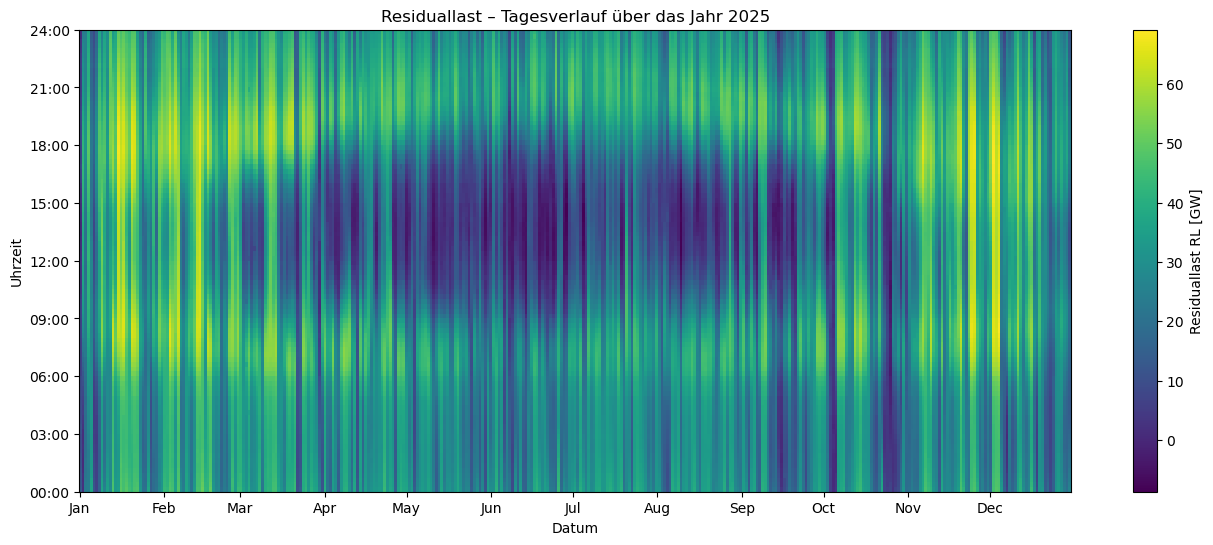

Xday shape (days, 96): (365, 96)
Zeitraum: 2025-01-01 → 2025-12-31


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
from datetime import time

# Nur Jahr 2025
df_2025 = df[df["ts"].dt.year == 2025].copy()

# Datum + Slot
df_2025["date"] = df_2025["ts"].dt.floor("D")
df_2025["slot"] = df_2025["ts"].dt.hour * 4 + (df_2025["ts"].dt.minute // 15)

# Tagesprofil-Matrix
Xday = df_2025.pivot_table(index="date", columns="slot", values="RL", aggfunc="mean")
Xday = Xday.reindex(columns=range(96)).sort_index()

# kleine Lücken füllen
Xday = Xday.interpolate(axis=1, limit_direction="both")

# X-Achse: echte Datumswerte
x_dates = mdates.date2num(Xday.index.to_pydatetime())

# Plot
plt.figure(figsize=(16,6))
img = plt.imshow(
    Xday.T.values,
    aspect="auto",
    origin="lower",
    interpolation="nearest",
    extent=[x_dates.min(), x_dates.max(), 0, 24]  # y jetzt 0–24 Stunden
)

plt.colorbar(img, label=f"Residuallast RL [{UNIT}]")
plt.title("Residuallast – Tagesverlauf über das Jahr 2025")
plt.xlabel("Datum")
plt.ylabel("Uhrzeit")

# X-Achse (Datum)
ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

# Y-Achse: echte Uhrzeiten
yticks = np.arange(0, 25, 3)  # alle 3 Stunden
plt.yticks(yticks, [f"{int(h):02d}:00" for h in yticks])

plt.grid(False)
plt.show()

print("Xday shape (days, 96):", Xday.shape)
print("Zeitraum:", Xday.index.min().date(), "→", Xday.index.max().date())

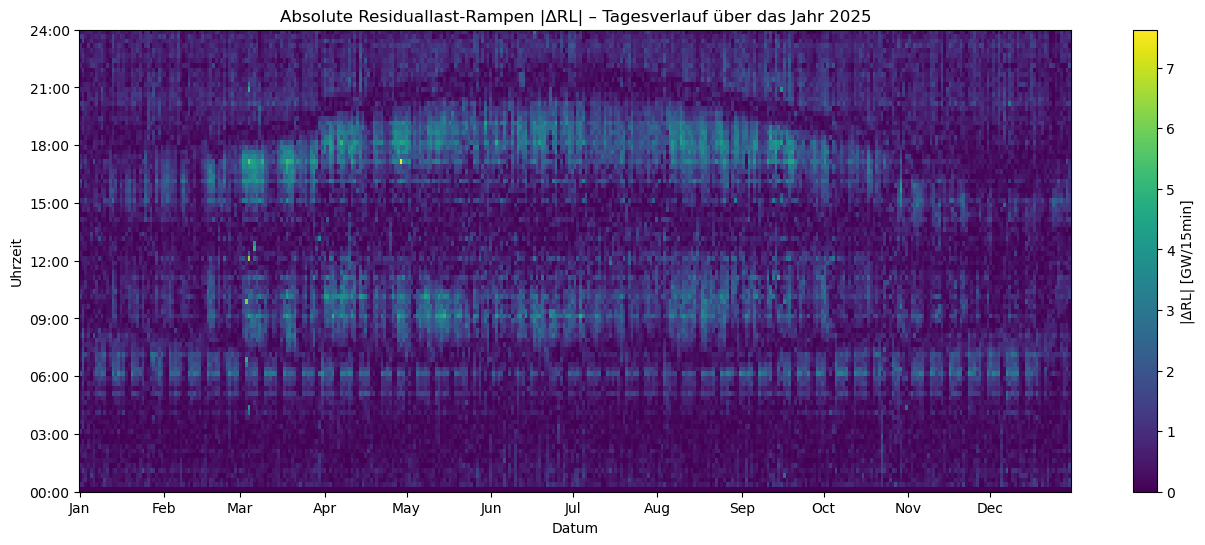

In [ ]:
# --- Rampenmatrix: |ΔRL| pro 15 min innerhalb eines Tages ---
# Xday: rows=Datum, cols=slot (0..95) mit RL

Xramp = Xday.diff(axis=1).abs()   # absolute Rampe je 15min
Xramp = Xramp.fillna(0.0)

plt.figure(figsize=(16,6))
img = plt.imshow(
    Xramp.T.values,
    aspect="auto",
    origin="lower",
    interpolation="nearest",
    extent=[x_dates.min(), x_dates.max(), 0, 24]
)

plt.colorbar(img, label=f"|ΔRL| [{UNIT}/15min]")
plt.title("Absolute Residuallast-Rampen |ΔRL| – Tagesverlauf über das Jahr 2025")
plt.xlabel("Datum")
plt.ylabel("Uhrzeit")

ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

yticks = np.arange(0, 25, 3)
plt.yticks(yticks, [f"{int(h):02d}:00" for h in yticks])

plt.grid(False)
plt.show()

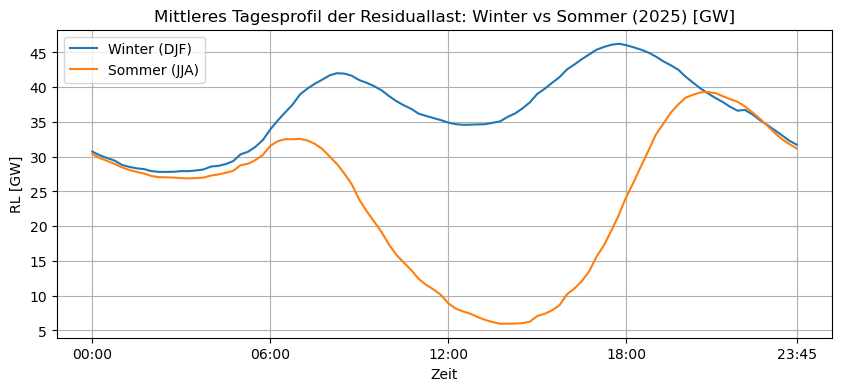

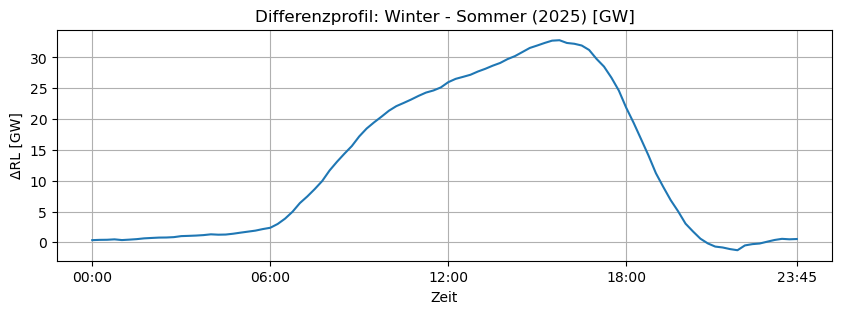

Anzahl Wintertage: 90 | Anzahl Sommertage: 92


In [ ]:
# --- Winter vs Sommer Vergleich ---
# Winter = Dez/Jan/Feb, Sommer = Jun/Jul/Aug

idx = Xday.index  # DatetimeIndex (Tage)
winter_mask = idx.month.isin([12, 1, 2])
summer_mask = idx.month.isin([6, 7, 8])

X_winter = Xday.loc[winter_mask]
X_summer = Xday.loc[summer_mask]

winter_mean = X_winter.mean(axis=0)  # 96er Tagesprofil
summer_mean = X_summer.mean(axis=0)

# Für Heatmap: gleiche Form wie Xday (96 x 1 "Tag") -> wir plotten als 96x1 Bild,
# schöner ist aber: Wir plotten die Mittelprofile als Linien UND optional eine Differenzkurve.
# Da du Heatmaps wolltest: wir bauen 96x1 Heatmaps (sehr kompakt) + Linienplot.

# 2a) Mittelprofile als Linien (am verständlichsten)
plt.figure(figsize=(10,4))
plt.plot(winter_mean.values, label="Winter (DJF)")
plt.plot(summer_mean.values, label="Sommer (JJA)")
plt.title(f"Mittleres Tagesprofil der Residuallast: Winter vs Sommer (2025) [{UNIT}]")
plt.xlabel("Zeit")
plt.ylabel(f"RL [{UNIT}]")
plt.xticks([0, 24, 48, 72, 95], ["00:00", "06:00", "12:00", "18:00", "23:45"])
plt.grid(True)
plt.legend()
plt.show()

# 2b) Differenzprofil (Winter - Sommer)
plt.figure(figsize=(10,3))
plt.plot((winter_mean - summer_mean).values)
plt.title(f"Differenzprofil: Winter - Sommer (2025) [{UNIT}]")
plt.xlabel("Zeit")
plt.ylabel(f"ΔRL [{UNIT}]")
plt.xticks([0, 24, 48, 72, 95], ["00:00", "06:00", "12:00", "18:00", "23:45"])
plt.grid(True)
plt.show()

print("Anzahl Wintertage:", X_winter.shape[0], "| Anzahl Sommertage:", X_summer.shape[0])

In [ ]:
# Gemeinsame Farbskala aus dem Gesamtjahr
vmin = np.nanpercentile(Xday.values, 5)
vmax = np.nanpercentile(Xday.values, 95)

print("Farbskala RL:", vmin, "bis", vmax, UNIT)

Farbskala RL: 3.249994 bis 53.941795999999975 GW


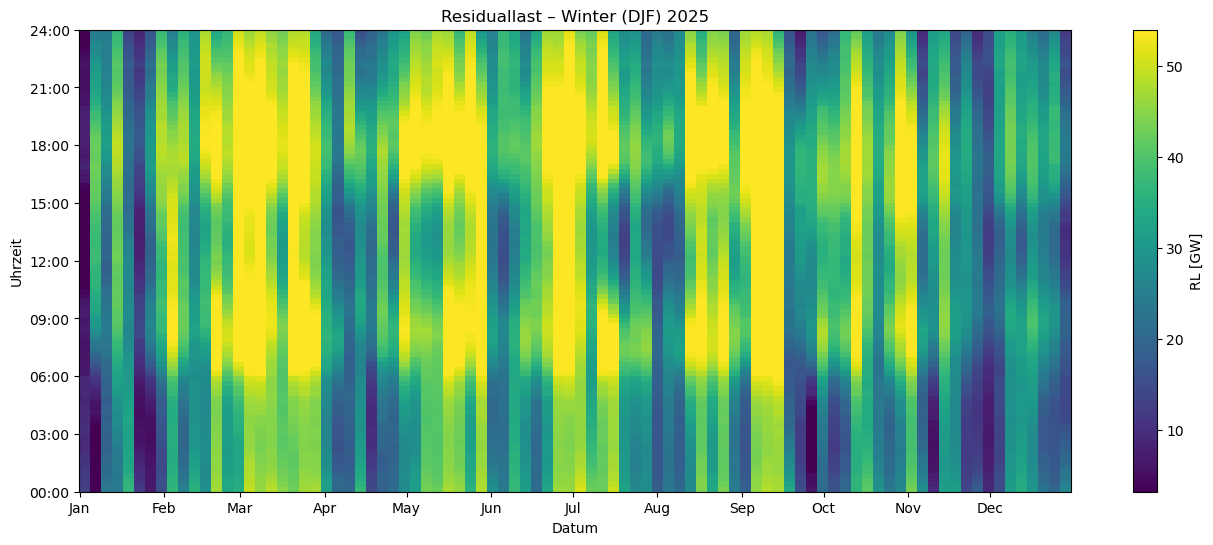

Wintertage: 90


In [ ]:
# --- Winter Heatmap (DJF) ---
idx = Xday.index
winter_mask = idx.month.isin([12, 1, 2])
X_winter = Xday.loc[winter_mask]

x_winter = mdates.date2num(X_winter.index.to_pydatetime())

plt.figure(figsize=(16,6))
img = plt.imshow(
    X_winter.T.values,
    aspect="auto",
    origin="lower",
    interpolation="nearest",
    extent=[x_winter.min(), x_winter.max(), 0, 24],
    vmin=vmin,
    vmax=vmax
)

plt.colorbar(img, label=f"RL [{UNIT}]")
plt.title("Residuallast – Winter (DJF) 2025")
plt.xlabel("Datum")
plt.ylabel("Uhrzeit")

ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

yticks = np.arange(0, 25, 3)
plt.yticks(yticks, [f"{int(h):02d}:00" for h in yticks])

plt.grid(False)
plt.show()

print("Wintertage:", X_winter.shape[0])

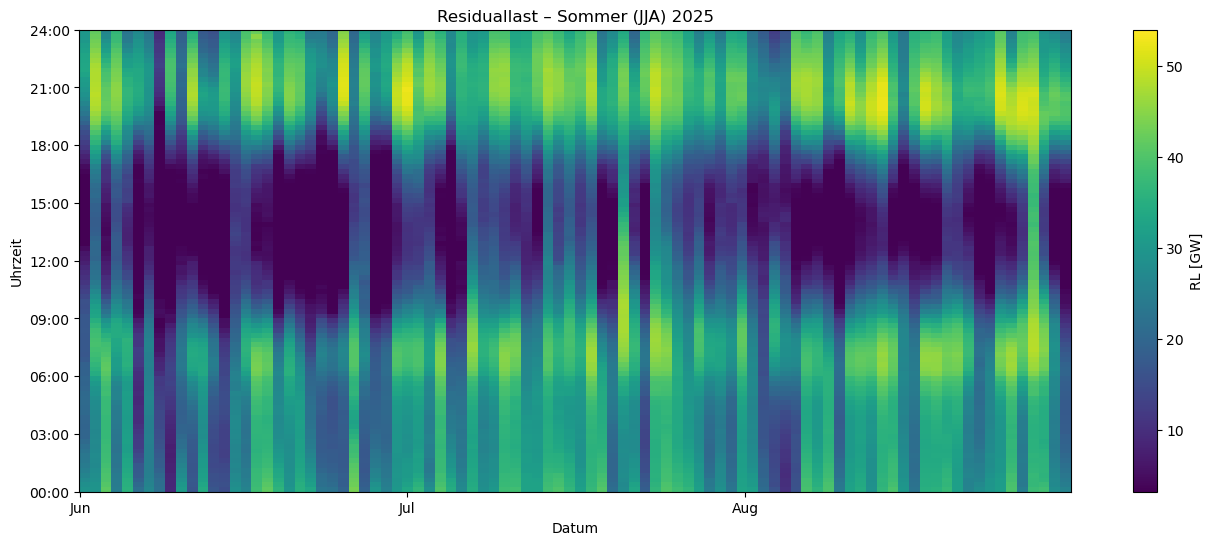

Sommertage: 92


In [ ]:
# --- Sommer Heatmap (JJA) ---
summer_mask = idx.month.isin([6, 7, 8])
X_summer = Xday.loc[summer_mask]

x_summer = mdates.date2num(X_summer.index.to_pydatetime())

plt.figure(figsize=(16,6))
img = plt.imshow(
    X_summer.T.values,
    aspect="auto",
    origin="lower",
    interpolation="nearest",
    extent=[x_summer.min(), x_summer.max(), 0, 24],
    vmin=vmin,
    vmax=vmax
)

plt.colorbar(img, label=f"RL [{UNIT}]")
plt.title("Residuallast – Sommer (JJA) 2025")
plt.xlabel("Datum")
plt.ylabel("Uhrzeit")

ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

yticks = np.arange(0, 25, 3)
plt.yticks(yticks, [f"{int(h):02d}:00" for h in yticks])

plt.grid(False)
plt.show()

print("Sommertage:", X_summer.shape[0])

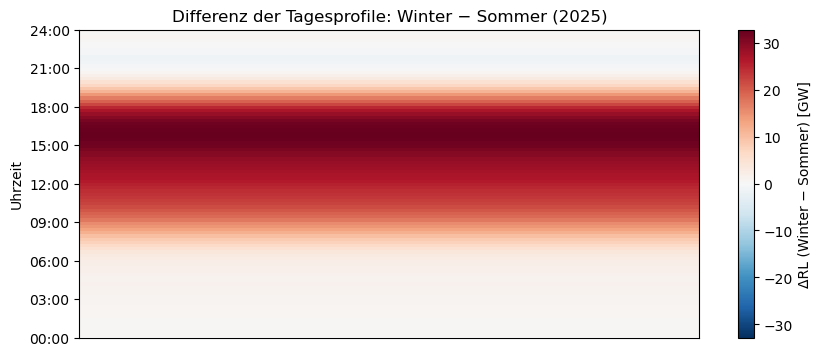

In [ ]:
# --- Differenz-Heatmap: Mittel(Winter) - Mittel(Sommer) ---
# Mittelprofile
winter_mean = X_winter.mean(axis=0)
summer_mean = X_summer.mean(axis=0)
diff = (winter_mean - summer_mean).values  # 96 Werte

# symmetrische Skala um 0
dmax = np.max(np.abs(diff))

# als Heatmap darstellen (repliziert für Darstellung)
diff_img = np.tile(diff.reshape(-1, 1), (1, 80))

plt.figure(figsize=(10,4))
img = plt.imshow(
    diff_img,
    aspect="auto",
    origin="lower",
    interpolation="nearest",
    extent=[0, 1, 0, 24],
    vmin=-dmax,
    vmax= dmax,
    cmap="RdBu_r"
)

plt.colorbar(img, label=f"ΔRL (Winter − Sommer) [{UNIT}]")
plt.title("Differenz der Tagesprofile: Winter − Sommer (2025)")
plt.ylabel("Uhrzeit")
plt.xlabel("")

yticks = np.arange(0, 25, 3)
plt.yticks(yticks, [f"{int(h):02d}:00" for h in yticks])
plt.xticks([])

plt.grid(False)
plt.show()

In [ ]:
# Nur Jahr 2025 (explizit)
df = df[df["ts"].dt.year == 2025].copy()

print("Zeitraum:", df["ts"].min(), "→", df["ts"].max())
print("Anzahl Viertelstunden:", len(df))

Zeitraum: 2025-01-01 00:00:00+01:00 → 2025-12-31 23:45:00+01:00
Anzahl Viertelstunden: 35040


In [ ]:
# Meteorologische Jahreszeiten
def season_from_month(m: int) -> str:
    if m in (12, 1, 2):
        return "Winter"
    if m in (3, 4, 5):
        return "Frühling"
    if m in (6, 7, 8):
        return "Sommer"
    return "Herbst"

df["month"] = df["ts"].dt.month
df["season"] = df["month"].apply(season_from_month)

# Slot 0..95 (Tageszeit)
df["slot"] = df["ts"].dt.hour * 4 + (df["ts"].dt.minute // 15)

df[["ts", "season", "slot", "RL"]].head()

,ts,season,slot,RL
0,2025-01-01 00:00:00+01:00,Winter,0,13.020
1,2025-01-01 00:15:00+01:00,Winter,1,12.100
2,2025-01-01 00:30:00+01:00,Winter,2,12.198
3,2025-01-01 00:45:00+01:00,Winter,3,12.100
4,2025-01-01 01:00:00+01:00,Winter,4,11.688


In [ ]:
# Mittelwert und Quantile je (season, slot)
season_profile = (
    df.groupby(["season", "slot"])["RL"]
      .agg(mean="mean",
           q25=lambda s: s.quantile(0.25),
           q75=lambda s: s.quantile(0.75))
      .reset_index()
)

season_profile.head()

,season,slot,mean,q25,q75
0,Frühling,0,31.274837,26.63213,37.31386
1,Frühling,1,30.743885,25.93556,36.82405
2,Frühling,2,30.397768,25.26861,36.58585
3,Frühling,3,30.037749,24.52826,36.27564
4,Frühling,4,29.615000,23.91880,36.01677


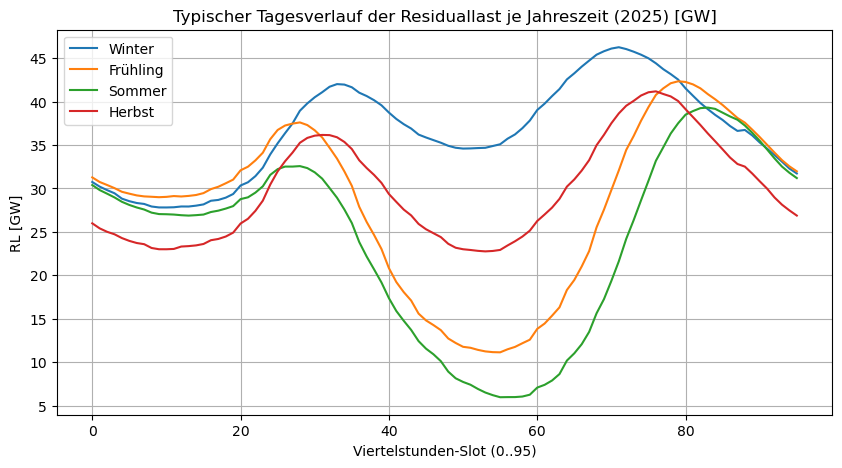

In [ ]:
plt.figure(figsize=(10,5))

for season in ["Winter", "Frühling", "Sommer", "Herbst"]:
    sub = season_profile[season_profile["season"] == season].sort_values("slot")
    plt.plot(sub["slot"], sub["mean"], label=season)

plt.title(f"Typischer Tagesverlauf der Residuallast je Jahreszeit (2025) [{UNIT}]")
plt.xlabel("Viertelstunden-Slot (0..95)")
plt.ylabel(f"RL [{UNIT}]")
plt.legend()
plt.grid(True)
plt.show()

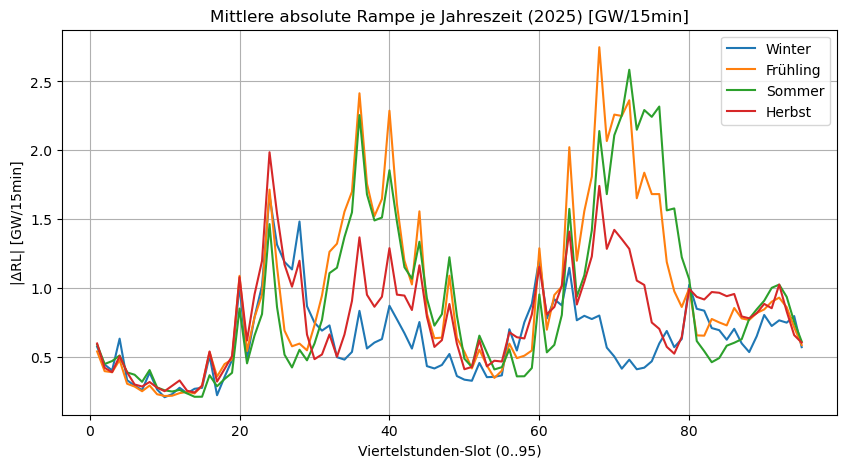

In [ ]:
# Rampen pro 15 min innerhalb eines Tages
df = df.sort_values("ts")
df["date"] = df["ts"].dt.date
df["ramp"] = df.groupby("date")["RL"].diff()  # Differenz innerhalb des Tages

ramp_profile = (
    df.dropna(subset=["ramp"])
      .groupby(["season", "slot"])["ramp"]
      .agg(mean_abs=lambda s: s.abs().mean(),
           q95_abs=lambda s: s.abs().quantile(0.95))
      .reset_index()
)

plt.figure(figsize=(10,5))
for season in ["Winter", "Frühling", "Sommer", "Herbst"]:
    sub = ramp_profile[ramp_profile["season"] == season].sort_values("slot")
    plt.plot(sub["slot"], sub["mean_abs"], label=season)

plt.title(f"Mittlere absolute Rampe je Jahreszeit (2025) [{UNIT}/15min]")
plt.xlabel("Viertelstunden-Slot (0..95)")
plt.ylabel(f"|ΔRL| [{UNIT}/15min]")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df["date"] = df["ts"].dt.date
df["slot"] = df["ts"].dt.hour * 4 + (df["ts"].dt.minute // 15)

X = df.pivot_table(index="date", columns="slot", values="RL", aggfunc="mean")

# Erzwinge genau 96 Slots (0..95)
X = X.reindex(columns=range(96))

# Wie viele Werte fehlen pro Tag?
missing_per_day = X.isna().sum(axis=1)
print("Tage insgesamt:", X.shape[0])
if missing_per_day.dropna().empty:
    print("WARNUNG: missing_per_day ist leer oder nur NaN")
else:
    print(
        "Fehlende Slots pro Tag (min/median/max):",
        int(missing_per_day.min(skipna=True)),
        int(missing_per_day.median(skipna=True)),
        int(missing_per_day.max(skipna=True))
    )

# Behalte Tage mit genügend Daten
X = X[missing_per_day <= (96 - MIN_SLOTS_PER_DAY)]
print("Tage nach Filter:", X.shape[0])

# Fehlende Slots innerhalb des Tages interpolieren (linear)
X = X.interpolate(axis=1, limit_direction="both")

# Falls am Rand noch NaN bleiben: mit Tagesmittel füllen
X = X.apply(lambda row: row.fillna(row.mean()), axis=1)

print("X shape (days, 96):", X.shape)
display(X.head())

Tage insgesamt: 365
Fehlende Slots pro Tag (min/median/max): 0 0 4
Tage nach Filter: 365
X shape (days, 96): (365, 96)


slot,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
date,,,,,,,,,,,,,,,,,,,,,
2025-01-01,13.020,12.100,12.198,12.100,11.688,10.921,10.759,10.401,9.781,9.274,...,5.275,5.058,5.895,5.509,4.878,3.995,3.119,3.029,1.641,1.270
2025-01-02,1.952,2.758,2.064,2.516,1.204,0.802,0.764,1.473,1.807,2.335,...,31.488,30.390,30.683,29.741,28.439,27.586,27.696,26.055,24.624,24.234
2025-01-03,23.348,23.165,22.267,21.551,20.844,21.133,20.779,20.048,19.515,19.200,...,25.690,25.546,25.826,25.330,24.867,25.212,25.332,25.126,24.537,23.922
2025-01-04,24.164,24.176,23.985,23.838,23.601,24.196,24.477,24.191,24.262,25.081,...,40.510,40.324,40.813,40.108,39.643,39.236,38.151,37.729,37.348,36.641
2025-01-05,36.886,36.482,36.134,34.747,33.919,33.623,33.343,32.998,32.765,32.422,...,17.153,17.045,18.219,17.125,16.810,16.026,15.820,14.890,14.243,13.476


In [ ]:
print("X shape:", X.shape)

X shape: (365, 96)


In [ ]:
std = X.std(axis=1)
valid_days = std[(std.notna()) & (std > 1e-9)].index

X_use = X.loc[valid_days]
X_norm = X_use.sub(X_use.mean(axis=1), axis=0).div(X_use.std(axis=1), axis=0)

print("X_use shape:", X_use.shape)
print("X_norm shape:", X_norm.shape)

if X_norm.shape[0] < 10:
    raise ValueError(f"Zu wenig gültige Tage zum Clustern: {X_norm.shape[0]}. "
                     f"Erhöhe MIN_SLOTS_PER_DAY nicht zu hoch oder prüfe Datenlücken.")

X_use shape: (365, 96)
X_norm shape: (365, 96)


In [ ]:
# Xday: rows = Tage, columns = 96 Viertelstunden, values = RL [GW]

X = Xday.copy()

print("Form von X:", X.shape)  # z.B. (365, 96)

Form von X: (365, 96)


In [ ]:
# z-Normierung pro Tag -> nur die Form zählt
X_norm = (
    X
    .sub(X.mean(axis=1), axis=0)
    .div(X.std(axis=1), axis=0)
)

# Sicherheitscheck
X_norm = X_norm.dropna()

print("Form von X_norm:", X_norm.shape)

Form von X_norm: (365, 96)


In [ ]:
from sklearn.cluster import KMeans

k = 5  # bewusst: wenige, gut interpretierbare Tagesformen

kmeans = KMeans(
    n_clusters=k,
    random_state=0,
    n_init=20
)

labels = kmeans.fit_predict(X_norm)

clusters = pd.Series(labels, index=X_norm.index, name="cluster")
clusters.value_counts()

cluster
0    134
4     77
3     73
1     53
2     28
Name: count, dtype: int64

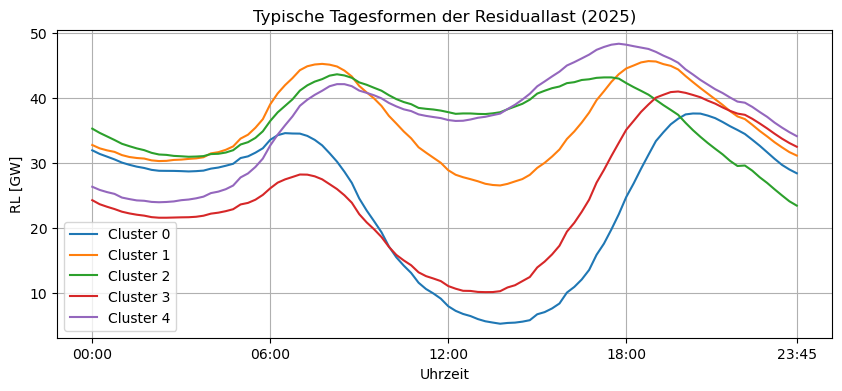

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

for c in sorted(clusters.unique()):
    mean_profile = X.loc[clusters == c].mean(axis=0)
    plt.plot(mean_profile.values, label=f"Cluster {c}")

plt.title("Typische Tagesformen der Residuallast (2025)")
plt.xlabel("Uhrzeit")
plt.ylabel("RL [GW]")
plt.xticks([0, 24, 48, 72, 95],
           ["00:00", "06:00", "12:00", "18:00", "23:45"])
plt.grid(True)
plt.legend()
plt.show()

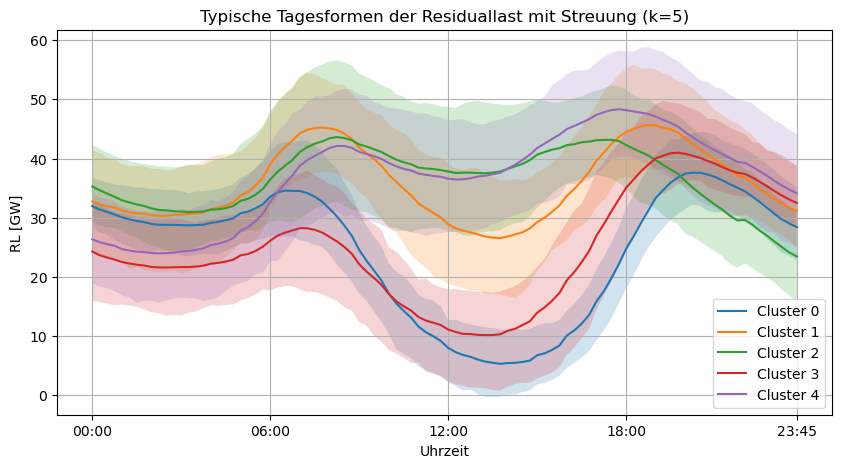

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

for c in sorted(clusters.unique()):
    data = Xday.loc[clusters == c]

    mean = data.mean(axis=0)
    q25  = data.quantile(0.25, axis=0)
    q75  = data.quantile(0.75, axis=0)

    plt.plot(mean.values, label=f"Cluster {c}")
    plt.fill_between(
        range(96), q25.values, q75.values, alpha=0.2
    )

plt.title("Typische Tagesformen der Residuallast mit Streuung (k=5)")
plt.xlabel("Uhrzeit")
plt.ylabel("RL [GW]")
plt.xticks([0, 24, 48, 72, 95],
           ["00:00", "06:00", "12:00", "18:00", "23:45"])
plt.legend()
plt.grid(True)
plt.show()

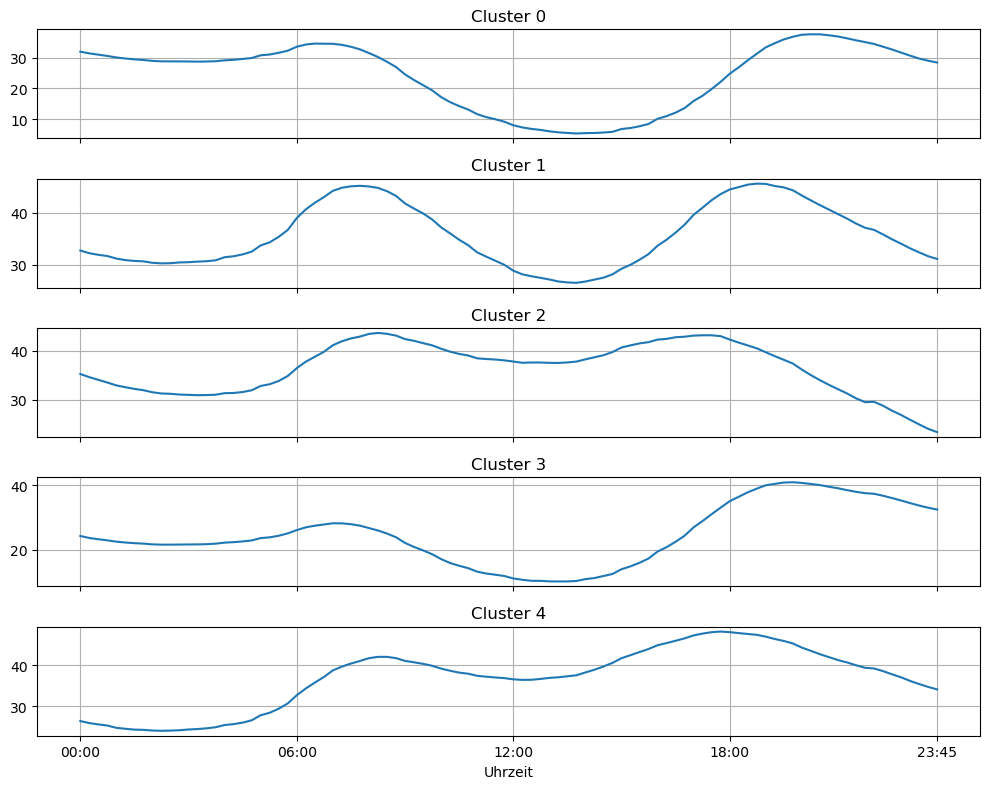

In [ ]:
fig, axes = plt.subplots(len(clusters.unique()), 1,
                         figsize=(10, 8),
                         sharex=True)

for ax, c in zip(axes, sorted(clusters.unique())):
    data = Xday.loc[clusters == c]

    ax.plot(data.mean(axis=0).values)
    ax.set_title(f"Cluster {c}")
    ax.grid(True)

axes[-1].set_xticks([0, 24, 48, 72, 95])
axes[-1].set_xticklabels(["00:00", "06:00", "12:00", "18:00", "23:45"])
plt.xlabel("Uhrzeit")
plt.tight_layout()
plt.show()

In [ ]:
# Tagesmittelwerte der Erzeugung
pv_day = df_2025.groupby("date")["PV"].mean()
wind_day = df_2025.groupby("date")["WIND"].mean()

print("PV days:", pv_day.shape)
print("Wind days:", wind_day.shape)

PV days: (365,)
Wind days: (365,)


In [ ]:
# Alles in einem DataFrame zusammenführen
ee_cluster = pd.DataFrame({
    "PV_mean": pv_day,
    "WIND_mean": wind_day,
    "cluster": clusters
}).dropna()

print("EE-Cluster-DF shape:", ee_cluster.shape)
ee_cluster.head()

EE-Cluster-DF shape: (365, 3)


,PV_mean,WIND_mean,cluster
date,,,
2025-01-01 00:00:00+01:00,2.365885,40.518469,0
2025-01-02 00:00:00+01:00,1.227948,26.558438,4
2025-01-03 00:00:00+01:00,1.264812,32.315354,4
2025-01-04 00:00:00+01:00,1.146927,13.169052,4
2025-01-05 00:00:00+01:00,0.378854,25.102781,2


In [ ]:
# Mittelwerte je Cluster
cluster_ee_summary = ee_cluster.groupby("cluster").agg(
    PV_mean=("PV_mean", "mean"),
    WIND_mean=("WIND_mean", "mean"),
    days=("cluster", "size")
)

cluster_ee_summary

,PV_mean,WIND_mean,days
cluster,,,
0,13.235294,11.458153,134
1,6.145787,14.277485,53
2,2.278478,19.450390,28
3,9.650254,16.634033,73
4,2.820960,19.124070,77


In [ ]:
# Normierung für Vergleichbarkeit
ee_norm = cluster_ee_summary.copy()

ee_norm["PV_norm"] = (
    ee_norm["PV_mean"] /
    (ee_norm["PV_mean"] + ee_norm["WIND_mean"])
)

ee_norm["WIND_norm"] = 1 - ee_norm["PV_norm"]

ee_norm[["PV_norm", "WIND_norm", "days"]]

,PV_norm,WIND_norm,days
cluster,,,
0,0.535984,0.464016,134
1,0.300921,0.699079,53
2,0.104859,0.895141,28
3,0.367149,0.632851,73
4,0.128547,0.871453,77


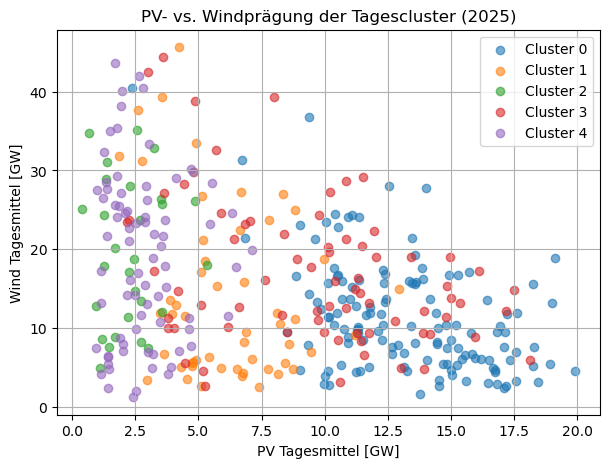

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

for c in sorted(ee_cluster["cluster"].unique()):
    sub = ee_cluster[ee_cluster["cluster"] == c]
    plt.scatter(
        sub["PV_mean"],
        sub["WIND_mean"],
        label=f"Cluster {c}",
        alpha=0.6
    )

plt.xlabel("PV Tagesmittel [GW]")
plt.ylabel("Wind Tagesmittel [GW]")
plt.title("PV- vs. Windprägung der Tagescluster (2025)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Hilfstabelle für Interpretation
interpretation = ee_norm.copy()
interpretation["Dominanz"] = np.where(
    interpretation["PV_norm"] > 0.6, "PV-dominiert",
    np.where(interpretation["PV_norm"] < 0.4, "Wind-dominiert", "Gemischt")
)

interpretation

,PV_mean,WIND_mean,days,PV_norm,WIND_norm,Dominanz
cluster,,,,,,
0,13.235294,11.458153,134,0.535984,0.464016,Gemischt
1,6.145787,14.277485,53,0.300921,0.699079,Wind-dominiert
2,2.278478,19.450390,28,0.104859,0.895141,Wind-dominiert
3,9.650254,16.634033,73,0.367149,0.632851,Wind-dominiert
4,2.820960,19.124070,77,0.128547,0.871453,Wind-dominiert


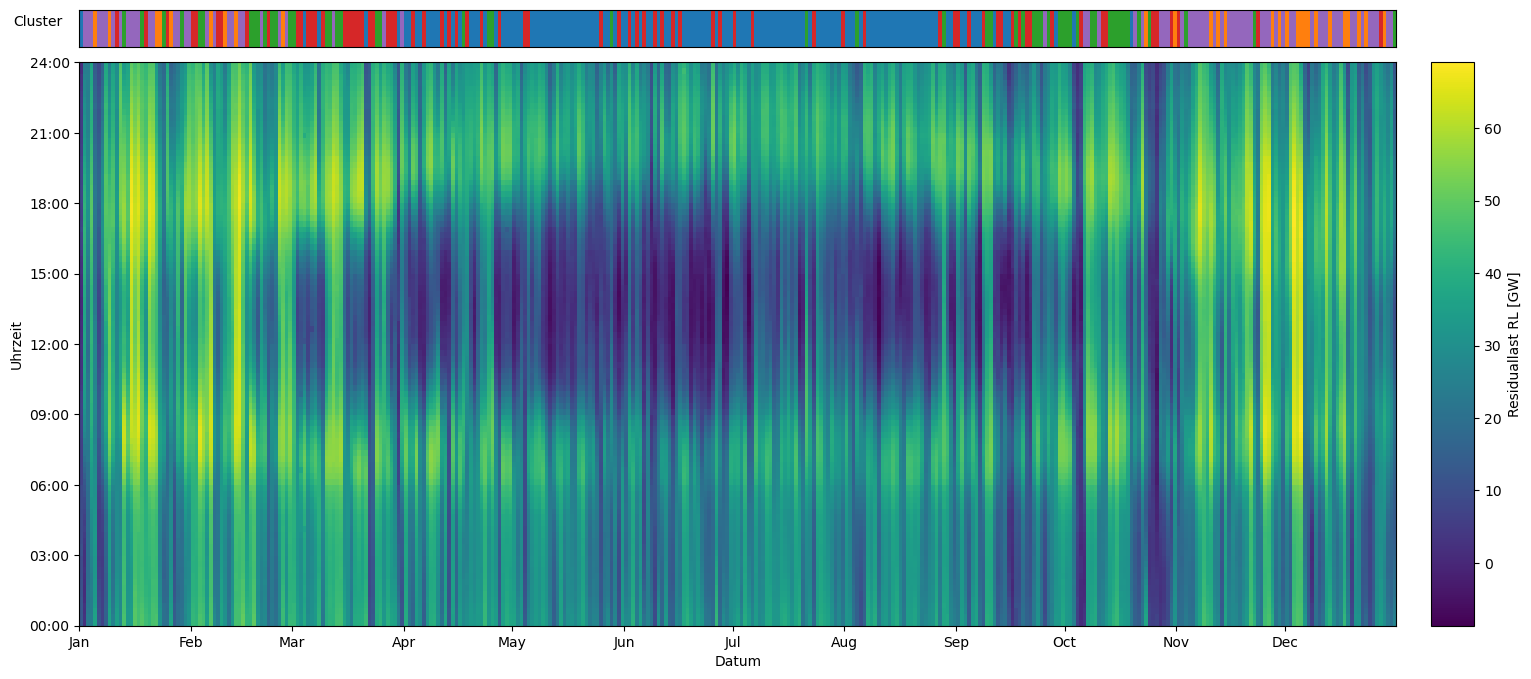

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# =========================
# Datenbasis
# =========================
X = Xday.copy()          # rows = Tage, cols = 96 Slots
dates = X.index
n_days = len(dates)

cluster_array = clusters.loc[dates].values.reshape(1, -1)

# =========================
# Clusterfarben (k=5)
# =========================
cluster_colors = ["#1f77b4", "#2ca02c", "#ff7f0e", "#d62728", "#9467bd"]
cluster_cmap = ListedColormap(cluster_colors)

# =========================
# Figure + Grid: 2 Zeilen, 2 Spalten
# links: Plots, rechts: Colorbar
# =========================
fig = plt.figure(figsize=(18, 8))
gs = fig.add_gridspec(
    2, 2,
    height_ratios=[0.8, 12],
    width_ratios=[30, 1],   # rechte Spalte = Colorbar
    hspace=0.05,
    wspace=0.05
)

ax_cluster = fig.add_subplot(gs[0, 0])
ax_heatmap = fig.add_subplot(gs[1, 0], sharex=ax_cluster)
cax = fig.add_subplot(gs[1, 1])  # eigene Achse für Colorbar

# =========================
# Cluster-Leiste (ohne Einfluss der Colorbar)
# =========================
ax_cluster.imshow(
    cluster_array,
    aspect="auto",
    cmap=cluster_cmap,
    interpolation="nearest",
    extent=[0, n_days, 0, 1]
)
ax_cluster.set_yticks([])
ax_cluster.set_ylabel("Cluster", rotation=0, labelpad=30)
ax_cluster.tick_params(axis="x", bottom=False, labelbottom=False)

# =========================
# Heatmap (gleiche Plotbreite wie Cluster-Leiste!)
# =========================
im = ax_heatmap.imshow(
    X.T.values,                # 96 x Tage
    aspect="auto",
    origin="lower",
    interpolation="nearest",
    extent=[0, n_days, 0, 24]
)

# Colorbar in eigener Spalte (beeinflusst Plotbreite nicht!)
cb = fig.colorbar(im, cax=cax)
cb.set_label("Residuallast RL [GW]")

# =========================
# Y-Achse: Uhrzeit
# =========================
ax_heatmap.set_ylabel("Uhrzeit")
ax_heatmap.set_yticks(np.arange(0, 25, 3))
ax_heatmap.set_yticklabels([f"{h:02d}:00" for h in range(0, 25, 3)])
ax_heatmap.set_ylim(0, 24)

# =========================
# X-Achse: Monate
# =========================
month_starts = dates[dates.is_month_start]
tick_pos = [dates.get_loc(d) for d in month_starts]
tick_labels = month_starts.strftime("%b")

ax_heatmap.set_xticks(tick_pos)
ax_heatmap.set_xticklabels(tick_labels)
ax_heatmap.set_xlabel("Datum")
ax_heatmap.set_xlim(0, n_days)

plt.show()

In [ ]:
summary = pd.DataFrame({
    "Amplitude [GW]": (Xday.max(axis=1) - Xday.min(axis=1)),
    "Mean RL [GW]": Xday.mean(axis=1)
}).join(clusters)

summary.groupby("cluster").mean()

,Amplitude [GW],Mean RL [GW]
cluster,,
0,36.089647,24.134122
1,23.950842,35.702541
2,23.590401,36.548299
3,34.017313,24.600108
4,25.931763,36.987234


In [ ]:
# Wie verteilen sich die Cluster übers Jahr?
cluster_calendar = clusters.to_frame()
cluster_calendar["month"] = pd.to_datetime(cluster_calendar.index).month

pd.crosstab(
    cluster_calendar["month"],
    cluster_calendar["cluster"],
    normalize="index"
)

cluster,0,1,2,3,4
month,,,,,
1,0.032258,0.129032,0.161290,0.096774,0.580645
2,0.000000,0.321429,0.142857,0.214286,0.321429
3,0.129032,0.225806,0.000000,0.548387,0.096774
4,0.633333,0.100000,0.000000,0.266667,0.000000
5,0.838710,0.032258,0.000000,0.129032,0.000000
6,0.700000,0.000000,0.000000,0.300000,0.000000
7,0.838710,0.032258,0.000000,0.129032,0.000000
8,0.838710,0.064516,0.000000,0.096774,0.000000
9,0.300000,0.333333,0.000000,0.333333,0.033333


In [ ]:
features_out = features.copy()
features_out.index = pd.to_datetime(features_out.index.astype(str))
features_out.sort_index().to_csv("cluster_features.csv", index_label="date")
print("Gespeichert: cluster_features.csv")

NameError: name 'features' is not defined